In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import quantum as qm
import asymmetric as asym
import scipy.linalg as spla

In [8]:
L = 7
_,_,_, sig_list = qm.get_sigma_lists(L)
H = asym.dense_H(L)
Z0 = sig_list[0]

In [24]:
end = 20; n = 3; tot = end*n
OTOCs = np.zeros((L,tot))
for i in range(tot):
    t = i/n
    U = spla.expm(-1j*H*t)
    Uinv = spla.expm(1j*H*t)
    for site in range(L):
        OTOCs[site, i] = 1-np.real((Uinv*Z0*U*sig_list[site]*Uinv*Z0*U*sig_list[site]).diagonal().sum())

/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:243: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:161: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


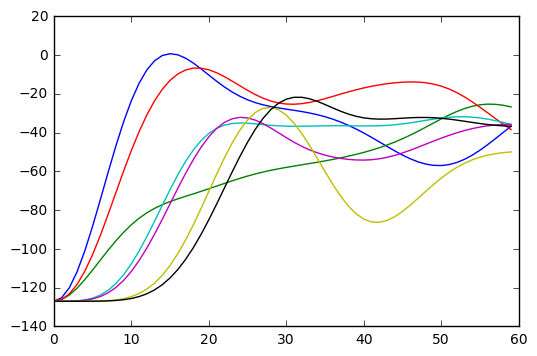

In [26]:
for site in range(L):
    plt.plot(OTOCs[site], label=site)
    plt.legend(loc=)